In [12]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pickle
# import tqdm

import utils

In [13]:
list_of_pits = pickle.load(open('../data/pit_info.p','rb'))

data_dir = '../data/kuka/required'


In [14]:
def plot_lines(pit,
               scale='log',
               align_ka_peak=False,
               shift_ka_peak=False,
               alignment_threshold=0.05,
               xmin=1.3,
               xmax=2.5,
               normalise=False,
               r2_weighting=False,
               plot=True,
               title=True,
               pol='vv',
               data_dir='../data/kuka/required'):
    
    freqranges, data_dict = utils.prepare_dicts(pit,pol,data_dir)
    all_data = utils.prepare_data(data_dict)

    argmaxs = {}
    maxs = {}
    
    return_dict = {}

    for freq in ['ku','ka']:
        
        range_diff=np.nan

        if scale == 'log':
            scan = np.log10(all_data[freq]['full_data'])
        elif scale == 'linear':
            scan = np.array(all_data[freq]['full_data'])
        else:
            raise
        
        # Times we started and stopped scanning
        
        time_begin = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_begin'][0],
                                                minute = pit[f'{freq}_begin'][1],
                                                second = pit[f'{freq}_begin'][2]))

        time_end = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_end'][0],
                                                minute = pit[f'{freq}_end'][1],
                                                second = pit[f'{freq}_end'][2]))

        # Convert times to array indexes, so we can slice the data
        
        start_index = utils.get_time_index(time_begin,
                                     all_data[freq]['times'])
        end_index = utils.get_time_index(time_end,
                                   all_data[freq]['times'])
        
        # Slice the data
        
        scan = scan[:,start_index:end_index]
        
        # Don't think this line is necessary?
#         y_tick_spacing=7

        # Average over the time slice

        line = np.mean(scan,axis=1)
        
        # Nan all the data outside of the range domain of interest

        line[freqranges[freq]<xmin] = np.nan
        line[freqranges[freq]>xmax] = np.nan
        
        # Option to divide by the square of the distance from the horn
        
        if r2_weighting:
            line = np.divide(line,np.square(freqranges[freq]))
        
        # This doesn't do anything anymore. To remove.
#         argmaxs[freq] = np.nanargmax(line)

        # Get max power for normalisation
        max_power = np.nanmax(line)
        
        # Create a normalised array from the power-range plot
        normline = line/abs(max_power)
        
        # Option to normalise your world
        if normalise:
            line = normline
            
        # Get the range bins
        ranges = freqranges[freq]
        
        # Raises an error if you try to auto-align and shift at same time
        if align_ka_peak and shift_ka_peak: raise
        
        # Option to align the Ka-band power-range plot with the Ku-band one.
        # This relies on Ku running before Ka, because it fills return_dict
        
        if align_ka_peak & (freq == 'ka'):
            
            # Normalise the Ku-band power (can't use the lines above, since they apply to Ka)
            
            ku_norm = return_dict['ku_values']/abs(np.nanmax(return_dict['ku_values']))
            
            # Get index of range bin where the normalised power first exceeds some threshold in each freq
            
            ku_thresh = np.argmax(ku_norm>alignment_threshold)
            ka_thresh = np.argmax(normline>alignment_threshold)
            
            # Indentify the indicies corresponding to all local maxima in the power-range plot

            ku_local_maxima = argrelextrema(ku_norm, np.greater)[0]
            ka_local_maxima = argrelextrema(normline, np.greater)[0]
            
            # Find range of nearest peak to range bin where power exceeds threshold
            
            ku_nearest_max = return_dict['ku_ranges'][ku_local_maxima[np.argmin(np.abs(ku_local_maxima-ku_thresh))]]
            ka_nearest_max = ranges[ka_local_maxima[np.argmin(np.abs(ka_local_maxima-ka_thresh))]]
            
            return_dict['ku_first_max'] = ku_nearest_max
            
            range_diff = ka_nearest_max-ku_nearest_max

#             range_diff_old = (freqranges['ka'][argmaxs['ka']]-freqranges['ku'][argmaxs['ku']])
            
            ranges = freqranges[freq] - range_diff
        
        else:
            range_diff = 0
        
        if np.array(shift_ka_peak).any() & (freq == 'ka'):
        
            range_diff = shift_ka_peak
            ranges = freqranges[freq] - range_diff
        
        return_dict[f'{freq}_ranges'] = ranges
        return_dict[f'{freq}_values'] = line
        return_dict[f'{freq}_range_diff'] = range_diff
        
    return return_dict

yticks = list(np.round(np.arange(1,0,-0.2),decimals=1)) + list(np.round(np.arange(0,1.01,0.2),decimals=1))

In [21]:
cp_vv

{'ku_ranges': array([-2.07      , -2.06542236, -2.06084473, ..., 16.66626709,
        16.67084473, 16.67542236]),
 'ku_values': array([nan, nan, nan, ..., nan, nan, nan]),
 'ku_range_diff': 0,
 'ku_first_max': 1.5692211914062502,
 'ka_ranges': array([-2.3522876 , -2.3446582 , -2.33702881, ..., 13.24982422,
        13.25745361, 13.26508301]),
 'ka_values': array([nan, nan, nan, ..., nan, nan, nan]),
 'ka_range_diff': -0.017712402343750266}

In [16]:
yticks = [1,0.5,0,0.5,1]

cps_vv = []
cps_hh = []
xps_hv = []
xps_vh = []
codes = []

# for counter, (ax,pit) in enumerate(zip(axs.reshape(-1),list_of_pits.values())):

align_ka_peak = False
    
for pit in list_of_pits.values():
    
    print(pit)
    
    code = pit['code']
    
    cp_vv = plot_lines(pit,scale='linear',
                normalise=False,
                align_ka_peak=True,
                pol='vv',
                r2_weighting=False,
                plot=False,
                  ) 
    cp_hh = plot_lines(pit,scale='linear',
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='hh',
                r2_weighting=False,
                plot=False,
                  ) 

    xp_hv = plot_lines(pit,scale='linear',
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='hv',
                r2_weighting=False,
                plot=False,
                    )   
    xp_vh = plot_lines(pit,scale='linear',
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='vh',
                r2_weighting=False,
                plot=False,
                    )   


    cps_vv.append(cp_vv)
    cps_hh.append(cp_hh)
    
    xps_hv.append(xp_hv)
    xps_vh.append(xp_vh)
    
    codes.append(code)


{'dir': 'PS129_kuka', 'code': 'D1 SP1', 'name': 'Day 1 SP 1', 'date': datetime.date(2022, 4, 11), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-101307.nc', 'kuka_stare_decon_Ku-Scat20220411-101807.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-101306.nc', 'kuka_stare_decon_Ka-Scat20220411-101806.nc'], 'ka_begin': (10, 18, 7), 'ka_end': (10, 19, 0), 'ku_begin': (10, 17, 30), 'ku_end': (10, 17, 55)}
{'dir': 'PS129_kuka', 'code': 'D1 SP2', 'name': 'Day 1 SP 2', 'date': datetime.date(2022, 4, 11), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-112811.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-112806.nc'], 'ka_begin': (11, 30, 11), 'ka_end': (11, 30, 52), 'ku_begin': (11, 28, 48), 'ku_end': (11, 29, 44)}
{'dir': 'PS129_kuka', 'code': 'D2 SP1', 'name': 'Day 2 SP 1', 'date': datetime.date(2022, 4, 16), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220416-150102.nc', 'kuka_stare_decon_Ku-Scat20220416-150602.nc', 'kuka_stare_decon_Ku-Scat20220416-151103.nc'], 'ka_f_names': 

In [17]:
data = {'hh': cps_hh,
        'vv': cps_vv,
        'hv': xps_hv,
        'vh': xps_vh,
        'code': codes}

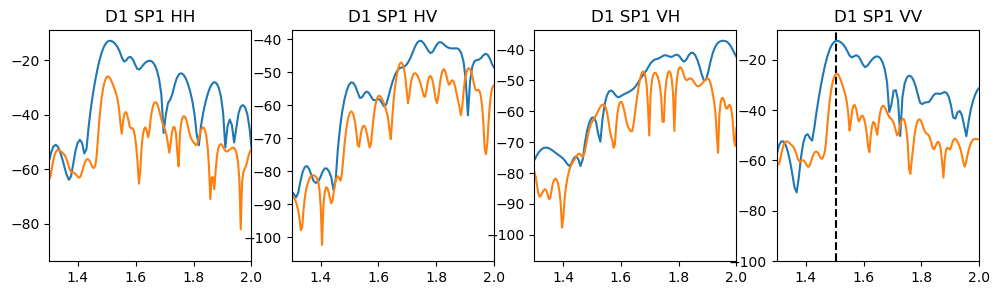

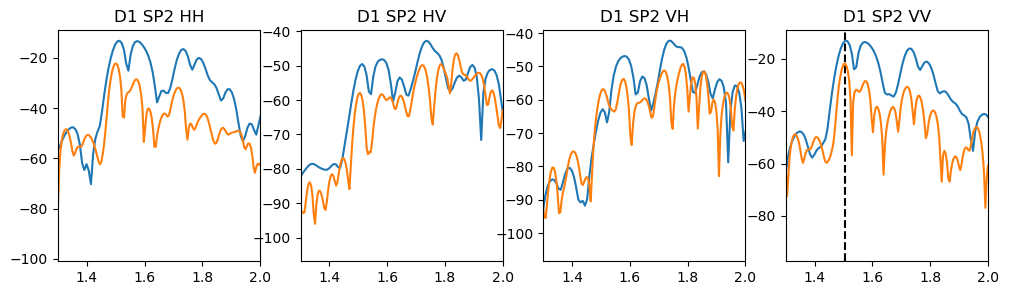

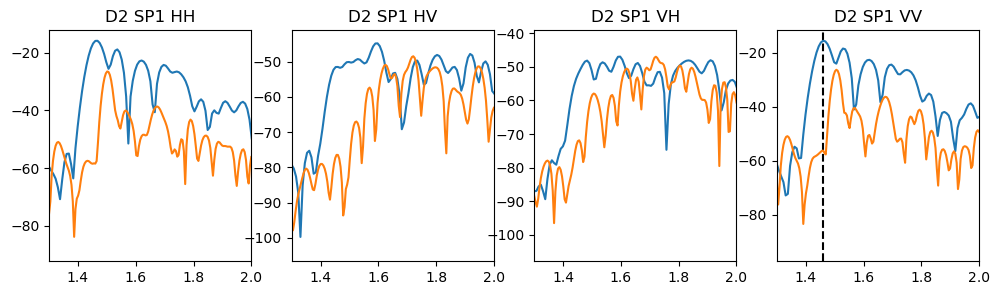

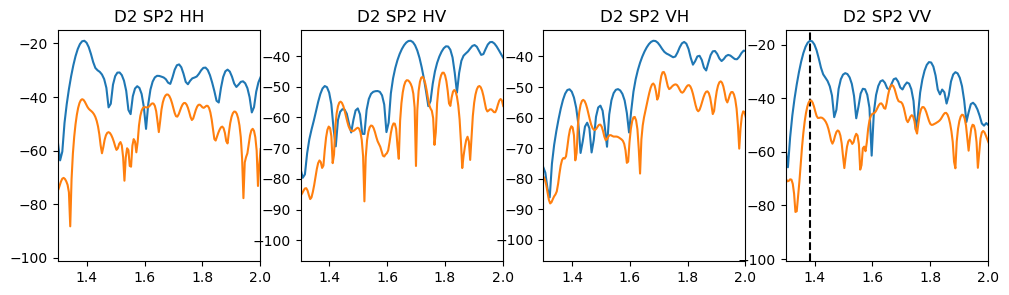

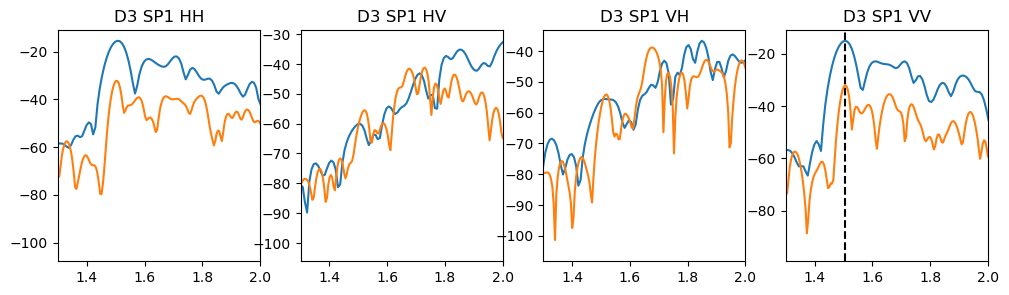

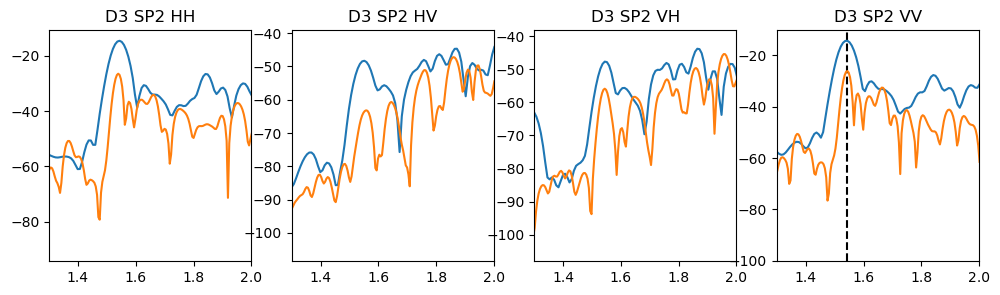

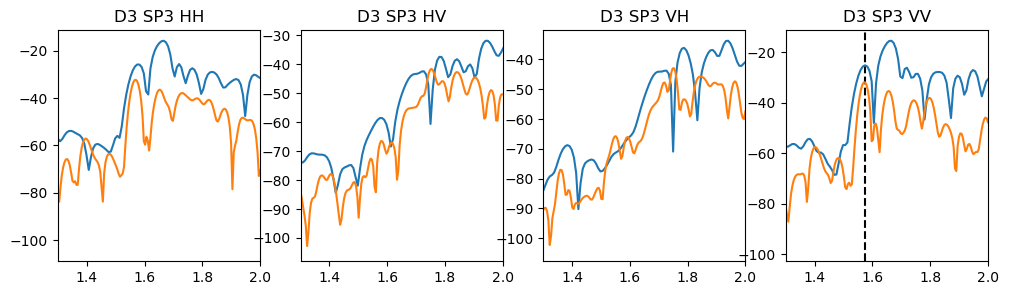

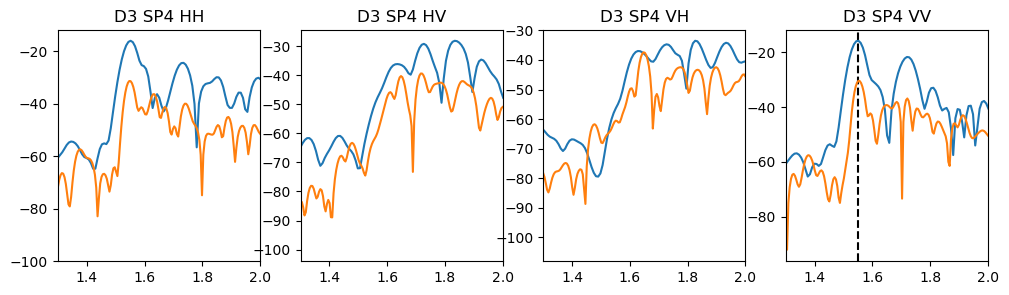

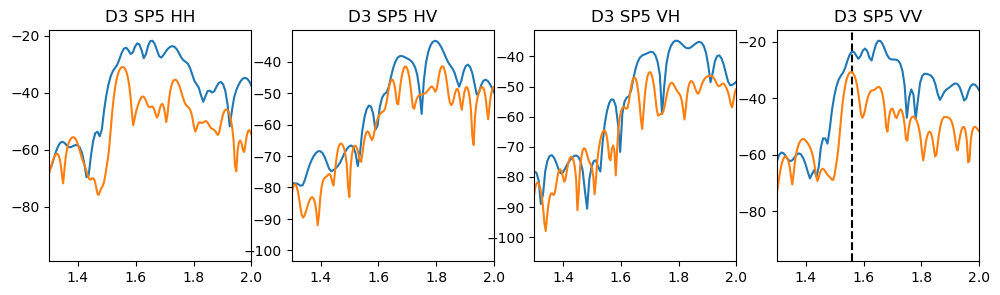

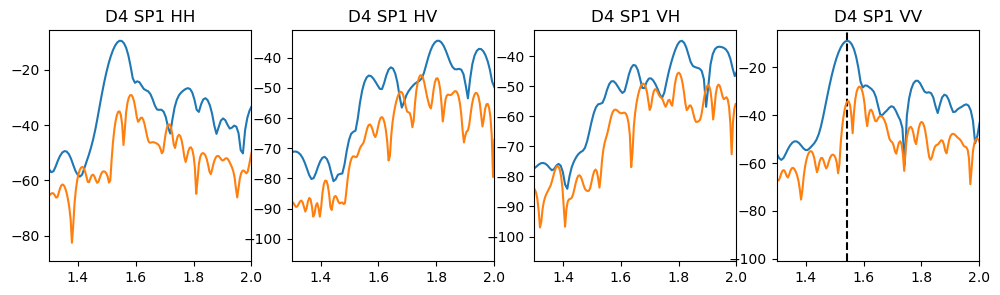

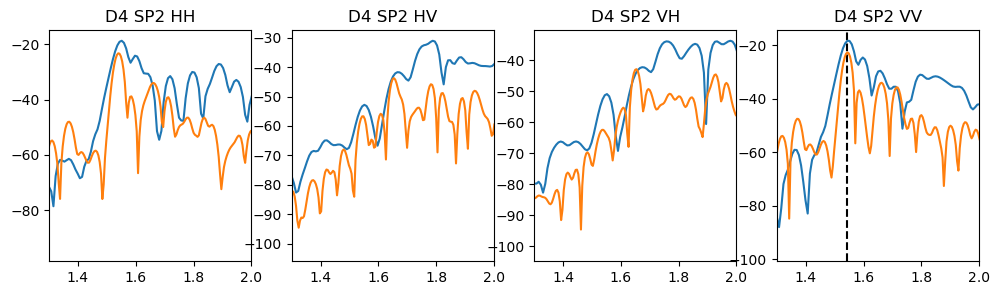

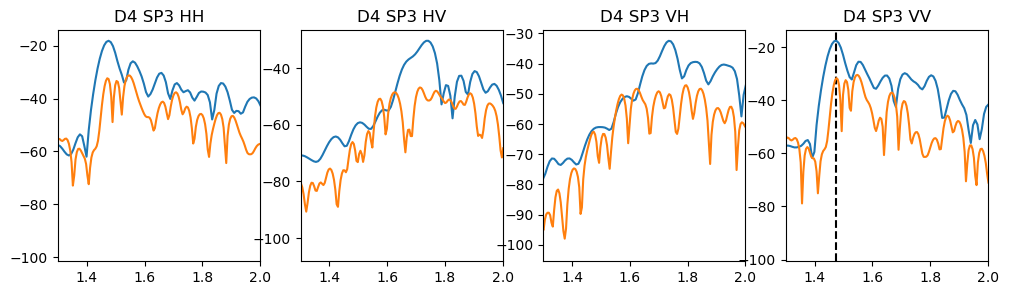

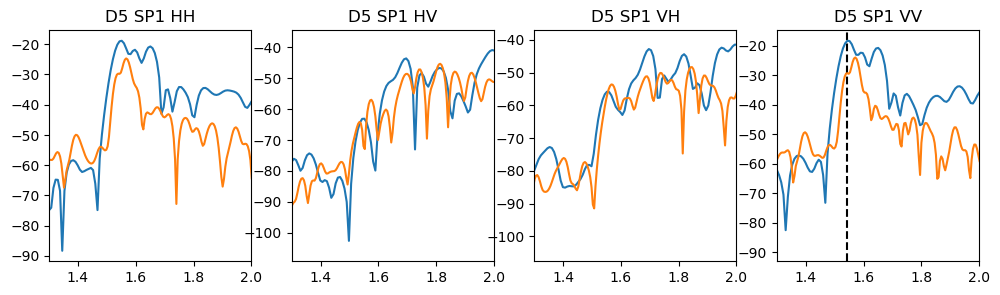

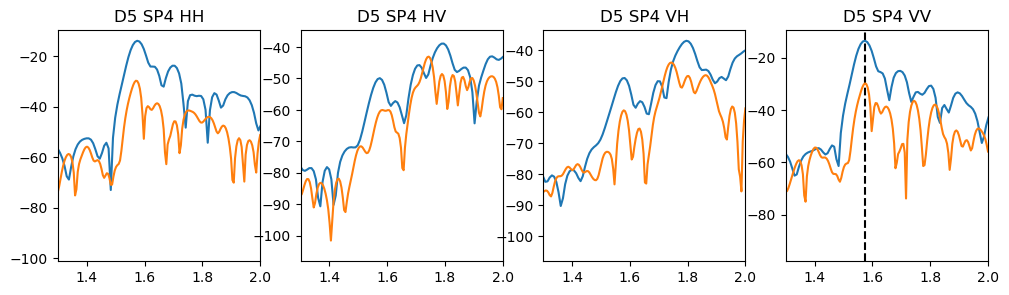

In [32]:
pols = ['hh', 'hv', 'vh', 'vv']

for i in range(17):
    f, ax = plt.subplots(1,4, figsize = (12, 3))

    for j in range(4):
        
        if pols[j] == 'vv':ax[j].axvline(data[pols[j]][i]['ku_first_max'],ls='--',color='k')
            
        ax[j].plot(data[pols[j]][i]['ku_ranges'], 10*np.log10(data[pols[j]][i]['ku_values']))
        ax[j].plot(data[pols[j]][i]['ka_ranges'], 10*np.log10(data[pols[j]][i]['ka_values']))
        ax[j].set_title(data['code'][i] + ' ' + pols[j].upper())
        ax[j].set_xlim(1.3,2)
    plt.show()
#     break


Up to here

In [26]:
# rr2r_df = pd.read_excel('../data/geophys/snowpits.ods',sheet_name='snow depths',)
rr2r_df = pd.read_csv('../data/geophys/snowpits_depths.csv')#,sheet_name='snow depths',)


rr2r_df.set_index('Pit Code',inplace=True)

def get_rr2r(code):
    
    rr2r = rr2r_df['radar_range_to_remnant'].loc[code]/100
    
    return rr2r

def get_rr2si(code):
    
    rr2r = rr2r_df['range_to_sea_ice'].loc[code]/100
    
    osd = rr2r_df['Old Snow Depth'].loc[code]/100
    
    return (rr2r,osd)

In [41]:
depths = pd.read_excel('../data/geophys/snowpits.ods',sheet_name='snow depths')

fig, axs = plt.subplots(4,4,figsize=(10,10))

for counter, (cp, xp, pit, ax) in enumerate(zip(cps,xps,list_of_pits.values(),axs.reshape(-1))):

    ax.plot(cp['ku_ranges']-cp['ku_first_max'],
            cp['ku_values'],
            color='darkblue',
            ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges']-cp['ku_first_max'],
            xp['ku_values'],
            color='darkblue',
            ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges']-cp['ku_first_max'],
            -cp['ka_values']
            ,color='crimson',
            ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges']-cp['ku_first_max'],
            -xp['ka_values']
            ,color='crimson',
            ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    ax.set_xlim(-0.1,1.1)
    
    try:
        rr2r = get_rr2r(pit['code'])
        ax.axvline(rr2r,ls=':',color='green',label='Remnant Snow\nSurface')
        
        rr2r,osd = get_rr2si(pit['code'])
        
        fraction = 0.15
        
        ax.axvspan(rr2r-fraction*osd,
                   rr2r+fraction*osd,
                   color='purple',alpha=0.1,label='Sea Ice Surface')
        
        
    except Exception as e:
        print(e)
        
    ax.annotate(pit['code'],xy=(0.98,0.02),
                 va='bottom',ha='right',
                 fontsize='large',
                 xycoords='axes fraction')
    

    ax.set_yticks(np.arange(-1,1.01,0.5))
    ax.set_yticklabels(yticks)    
    
    if counter == 1:
        ax.legend(loc='center',fontsize='x-large',ncol=3,bbox_to_anchor=(0.5,1.4))
    
    ax.set_xticks(np.arange(0,1.01,0.2))
    
    ax.xaxis.set_ticks_position('both')
    if counter <4:
        ax.tick_params(labelbottom=False,labeltop=True)
    elif counter > 11:
        ax.tick_params(labelbottom=True,labeltop=False)
    else:
        ax.set_xticklabels([])
        ax.tick_params(labelbottom=False,labeltop=False)
        
    ax.yaxis.set_ticks_position('both')
    
    if counter in [0,4,8,12]:
        ax.tick_params(labelleft=True)
    elif counter in [3,7,11,15]:
        ax.tick_params(labelleft=False,labelright=True)
    else:
        ax.set_yticklabels([])
        
    ax.axhline(0,color='k')
    
    if counter == 4: ax.set_ylabel('Weighted Returned Power (normalised)',
                                   fontsize='x-large',va='bottom',ha='right')

    if counter == 12: ax.set_xlabel('Adjusted Radar Range Below Snow Surface (m)',fontsize='x-large',ha='left')

space= 0.07
        
fig.subplots_adjust(wspace=space,hspace=space)

# plt.show()
plt.savefig(f'../figures/all_pits.jpg',dpi=300,bbox_inches='tight')

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/KuKa_Weddell'

plt.savefig(f'{overleaf_dir}/main_figs/Fig2.jpg',dpi=300,bbox_inches='tight')
#     plt.close()

unsupported operand type(s) for /: 'str' and 'int'
unsupported operand type(s) for /: 'str' and 'int'
unsupported operand type(s) for /: 'str' and 'int'
unsupported operand type(s) for /: 'str' and 'int'


In [82]:
p = {}

for number,pit in enumerate(list_of_pits.values()):
    

    r2_weighting = (0,0,1)
    adjust = (0,1,1)
    
    p[pit['name']] = {}
    
    for r2, adjust in zip(r2_weighting,
                              adjust):

        cp = plot_lines(pit,scale='linear',
                       normalise=True,
                       align_ka_peak=adjust,
                        pol='vv',
                        r2_weighting=r2,
                          )

        xp = plot_lines(pit,scale='linear',
                   normalise=True,
                   shift_ka_peak=cp['ka_range_diff'],
                    pol='vh',
                    r2_weighting=r2,
                      )
        
        p[pit['name']][(r2,adjust)] = (cp,xp)
        
#     break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [10]:
for pit in list_of_pits.values():
    
    print(pit['code'])

D1 SP1
D1 SP2
D2 SP1
D2 SP2
D3 SP1
D3 SP2
D3 SP3
D3 SP4
D3 SP5
D4 SP1
D4 SP2
D4 SP3
D5 SP1
D5 SP2
D5 SP3
D5 SP4
D5 SP5


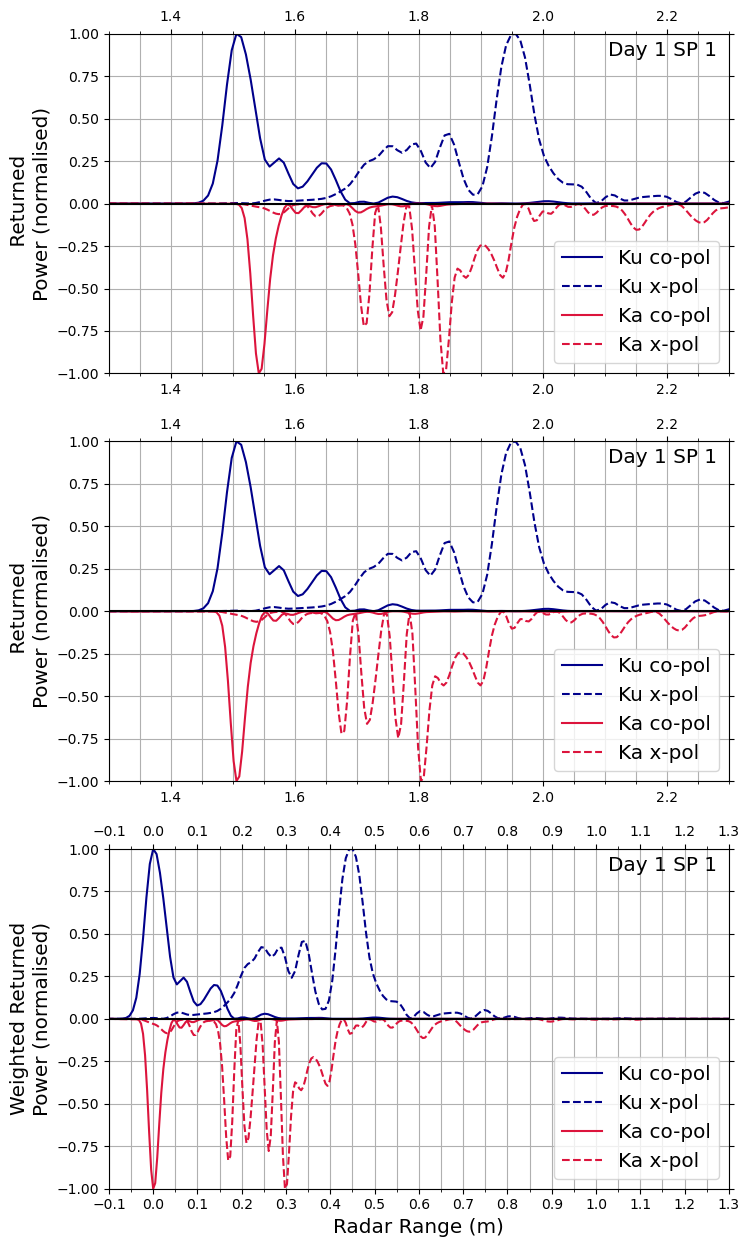

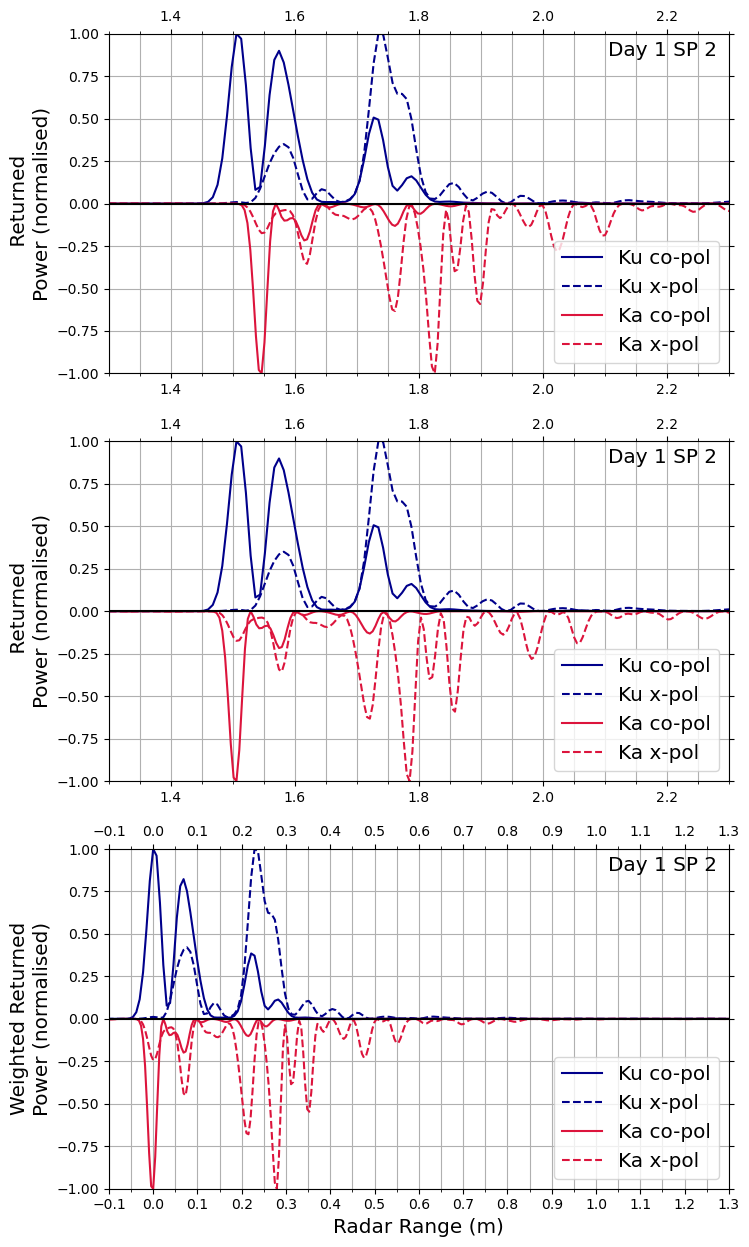

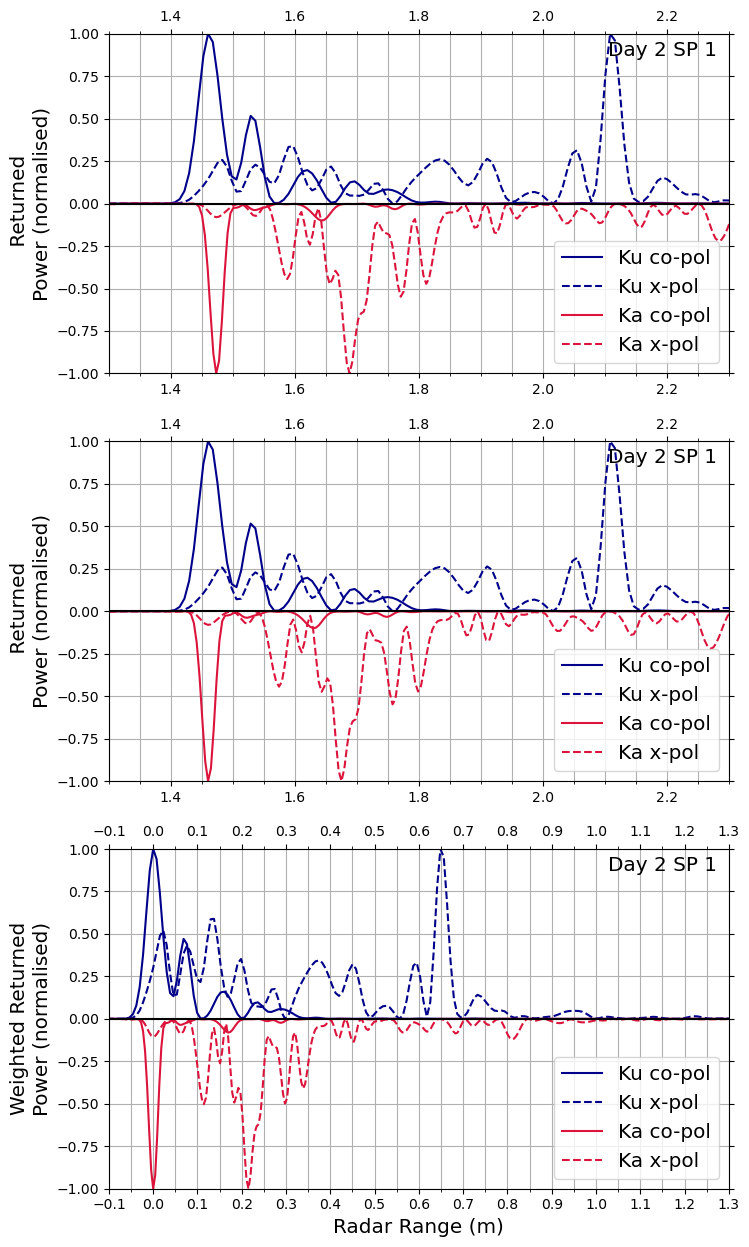

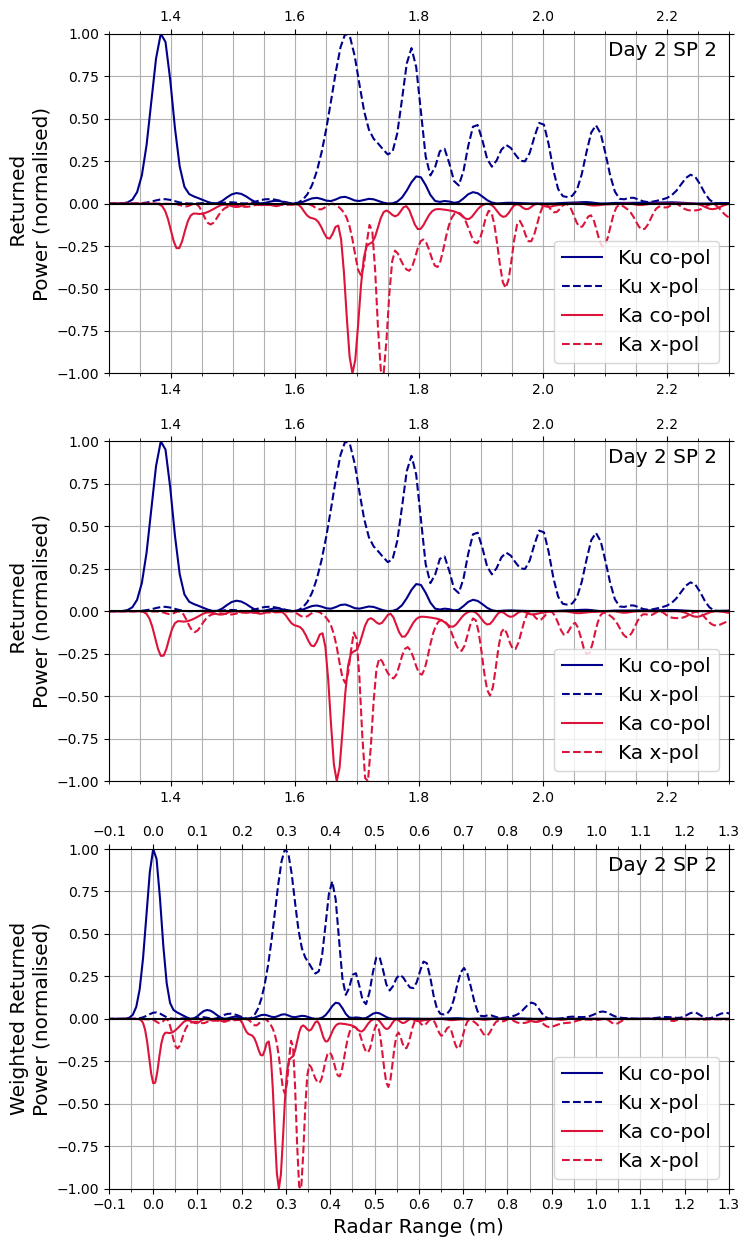

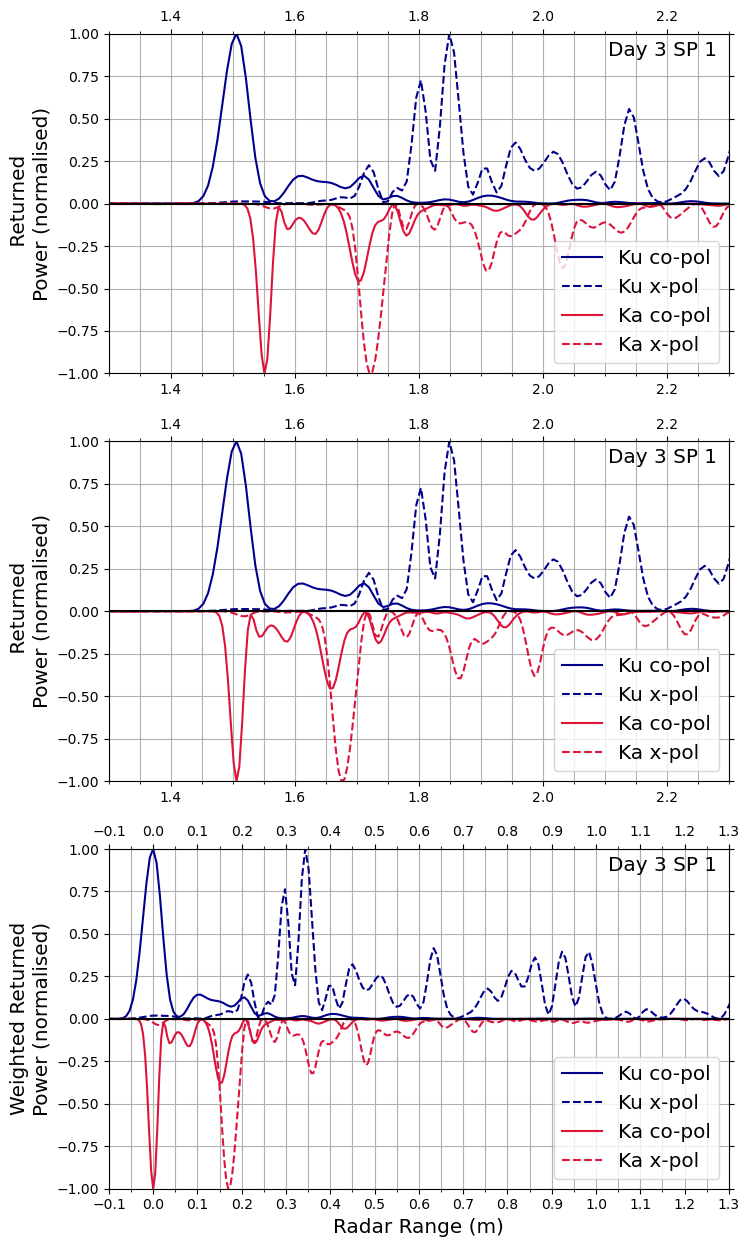

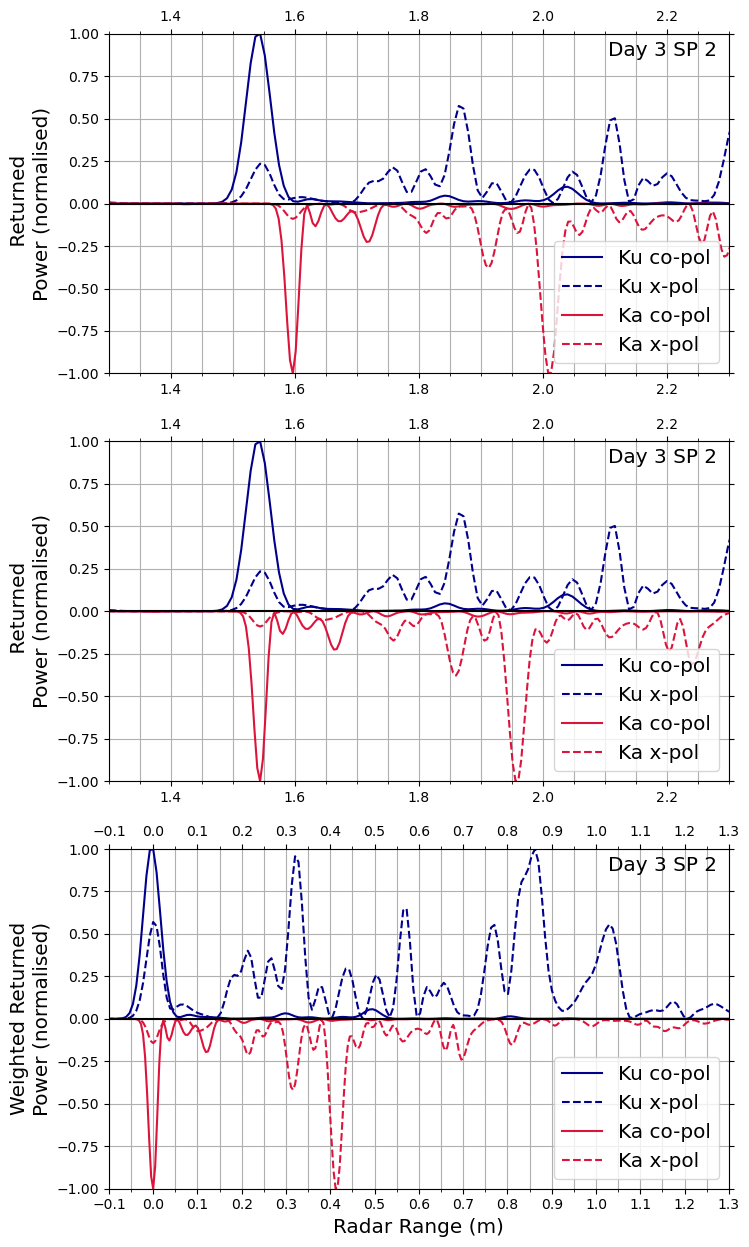

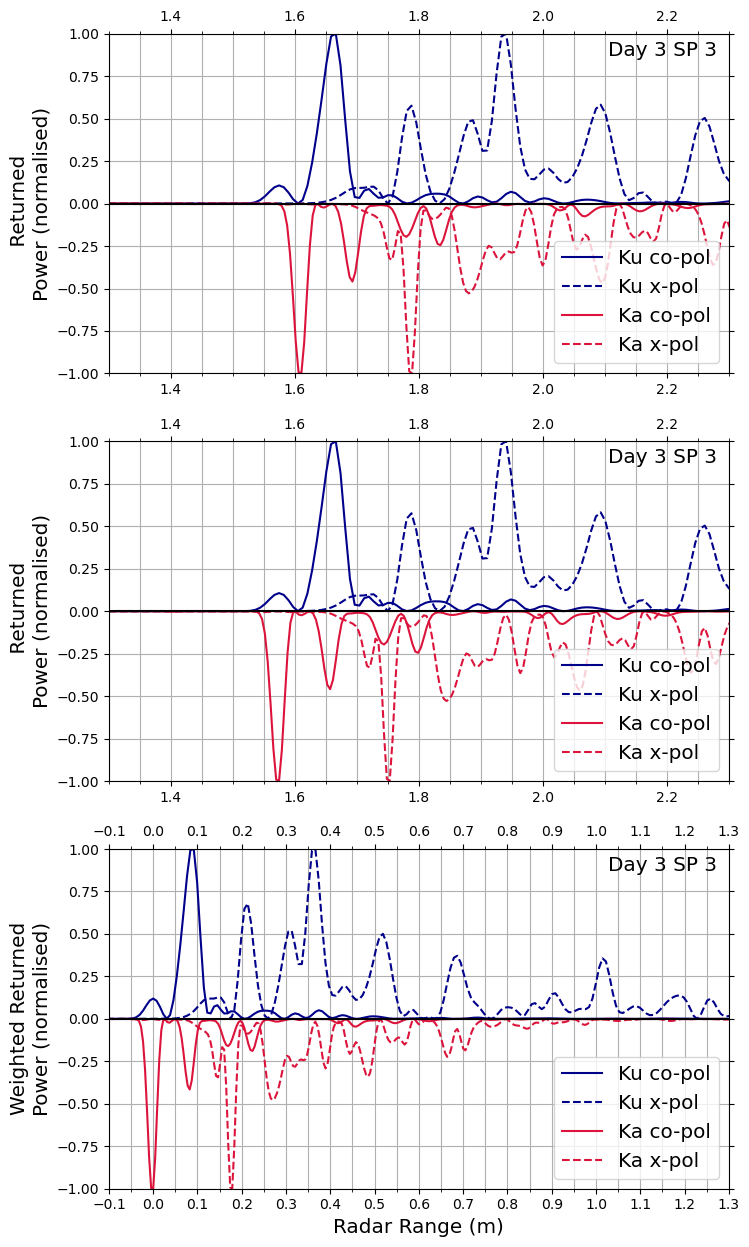

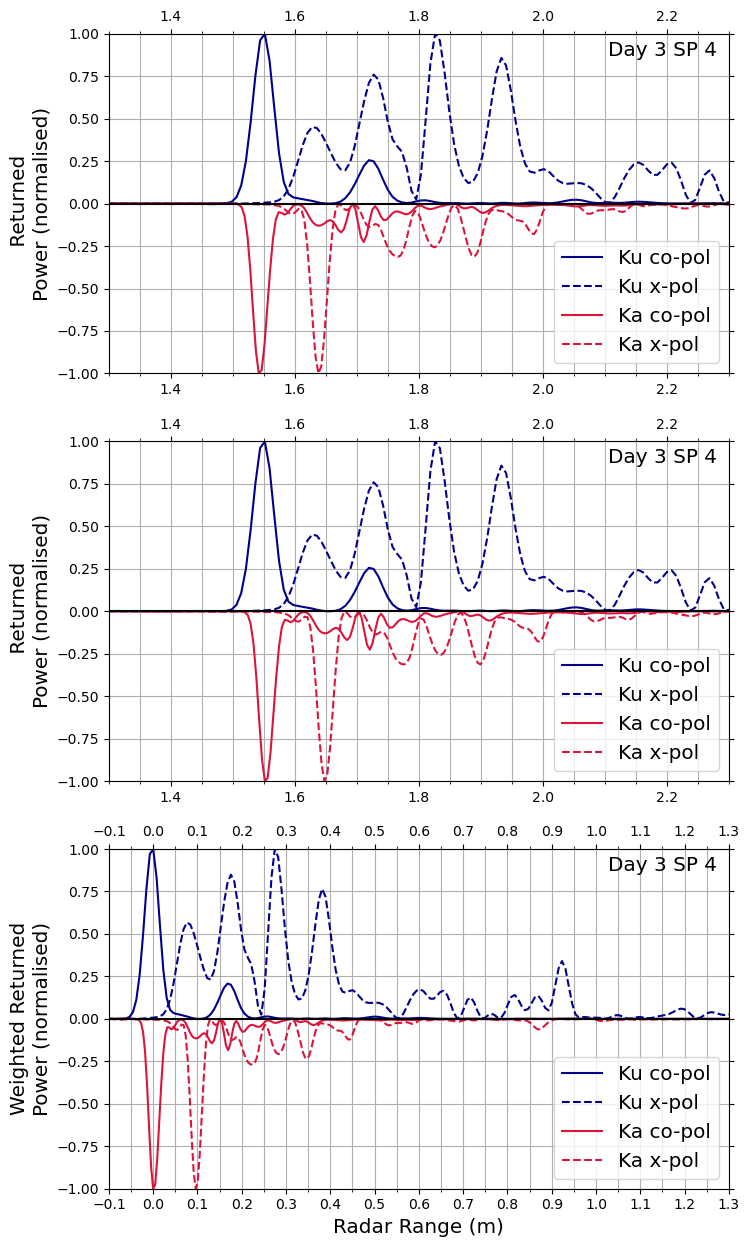

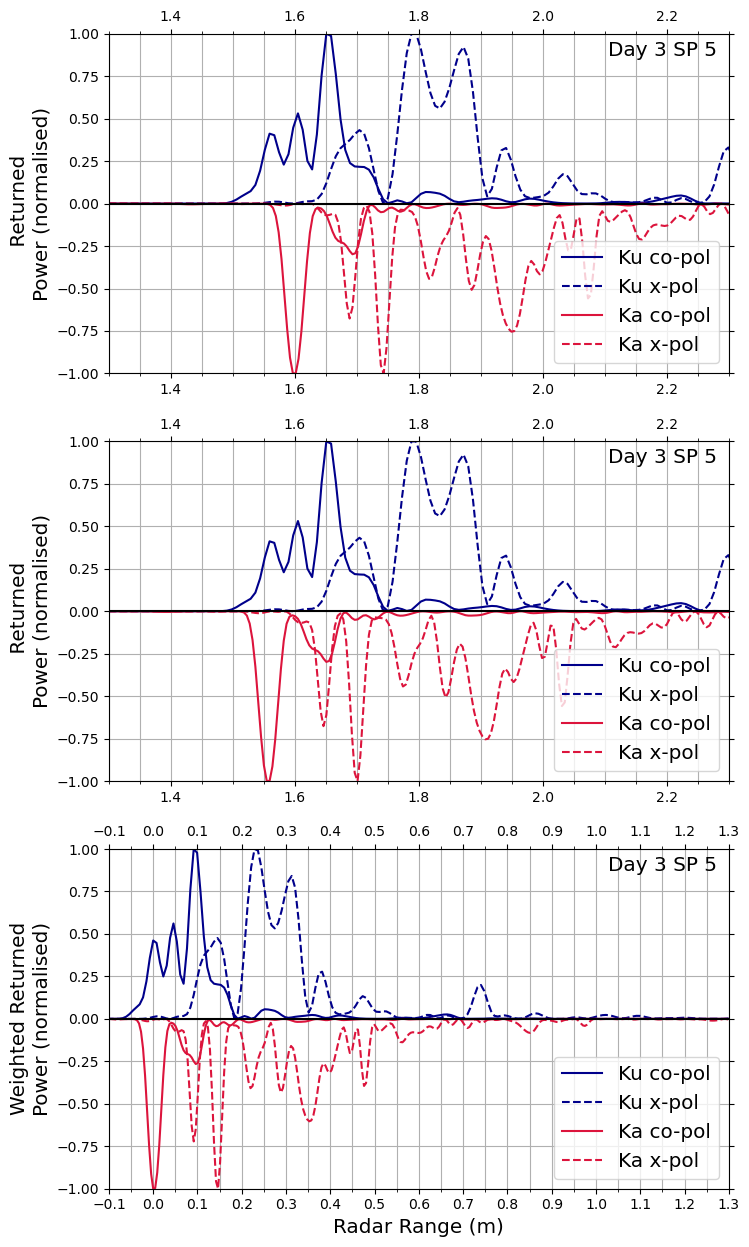

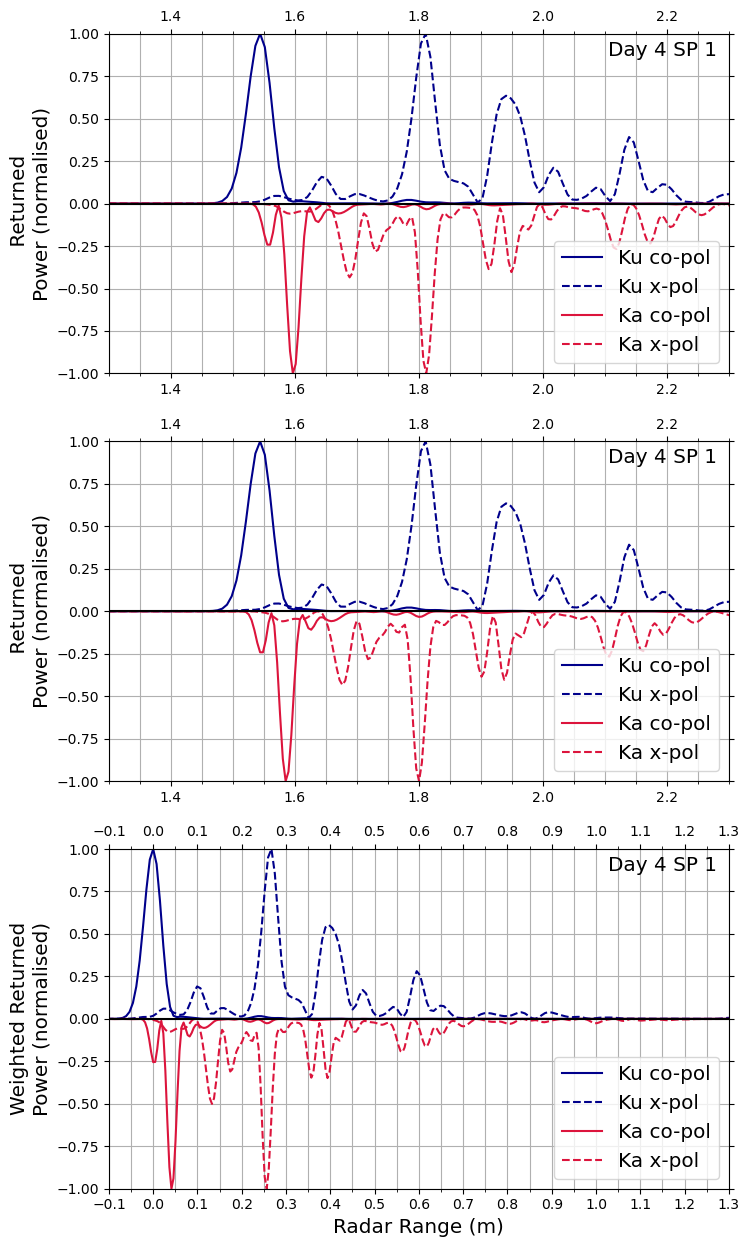

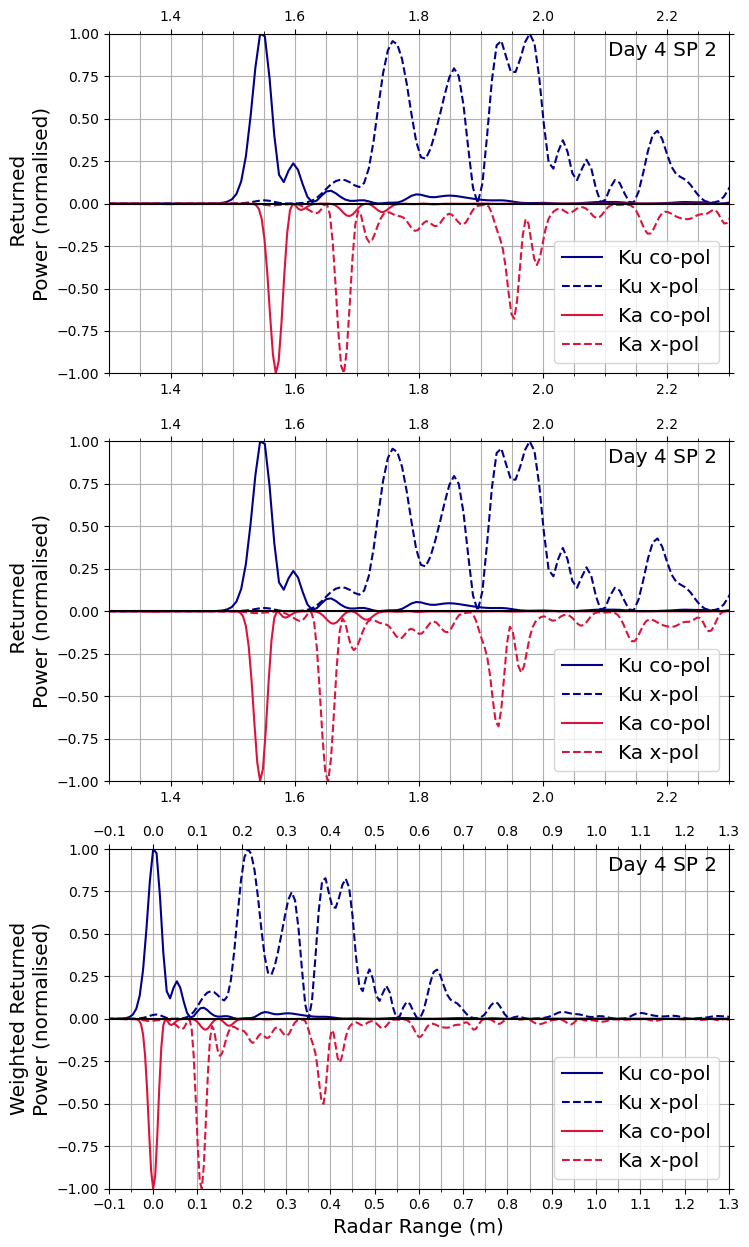

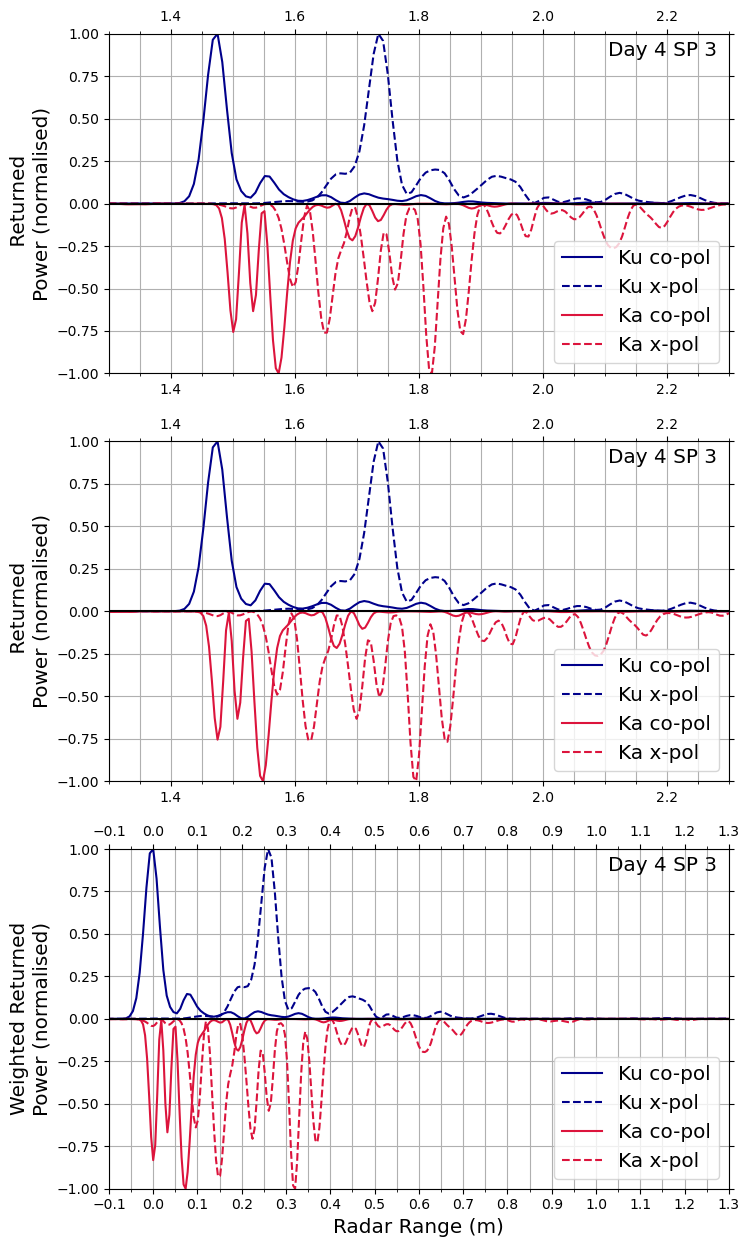

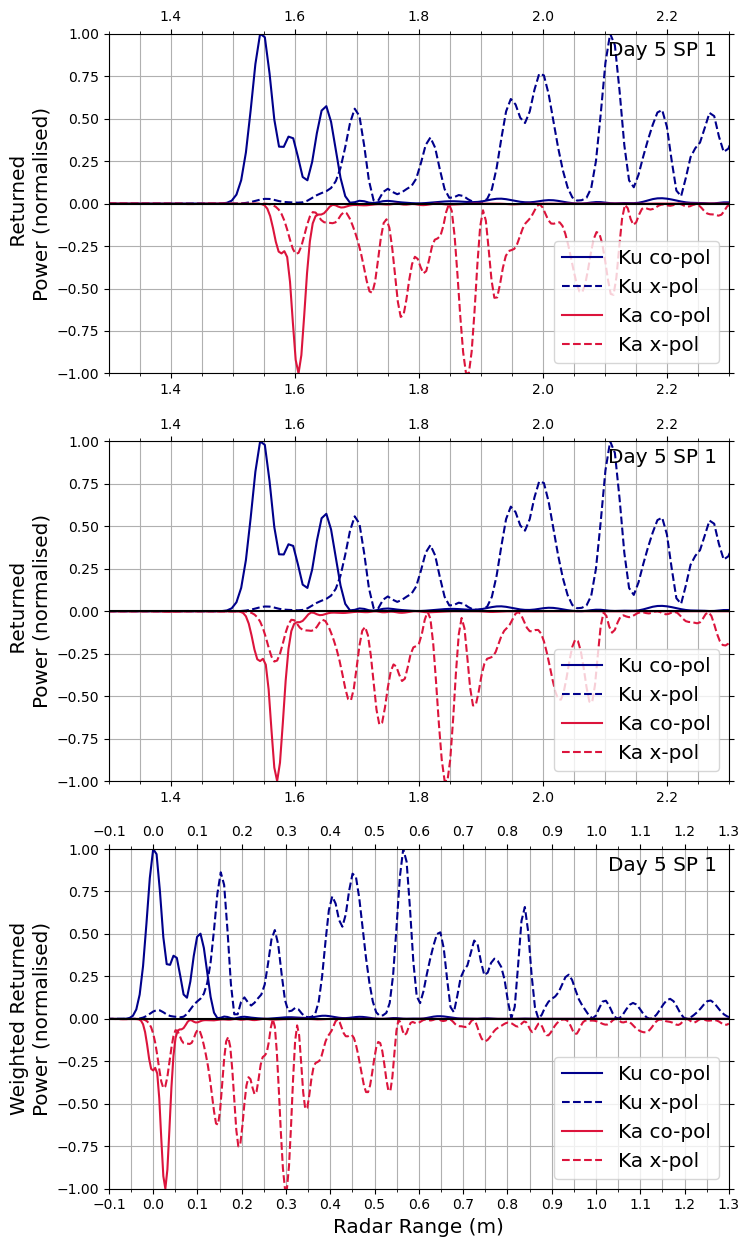

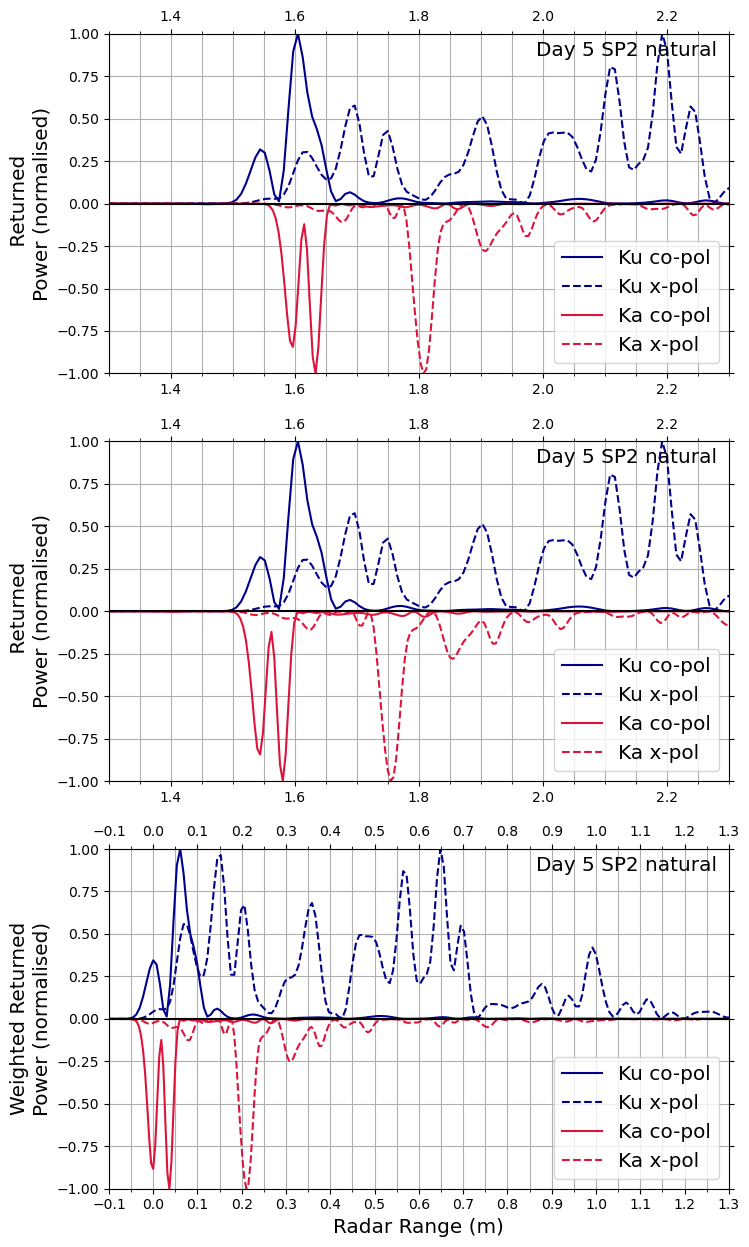

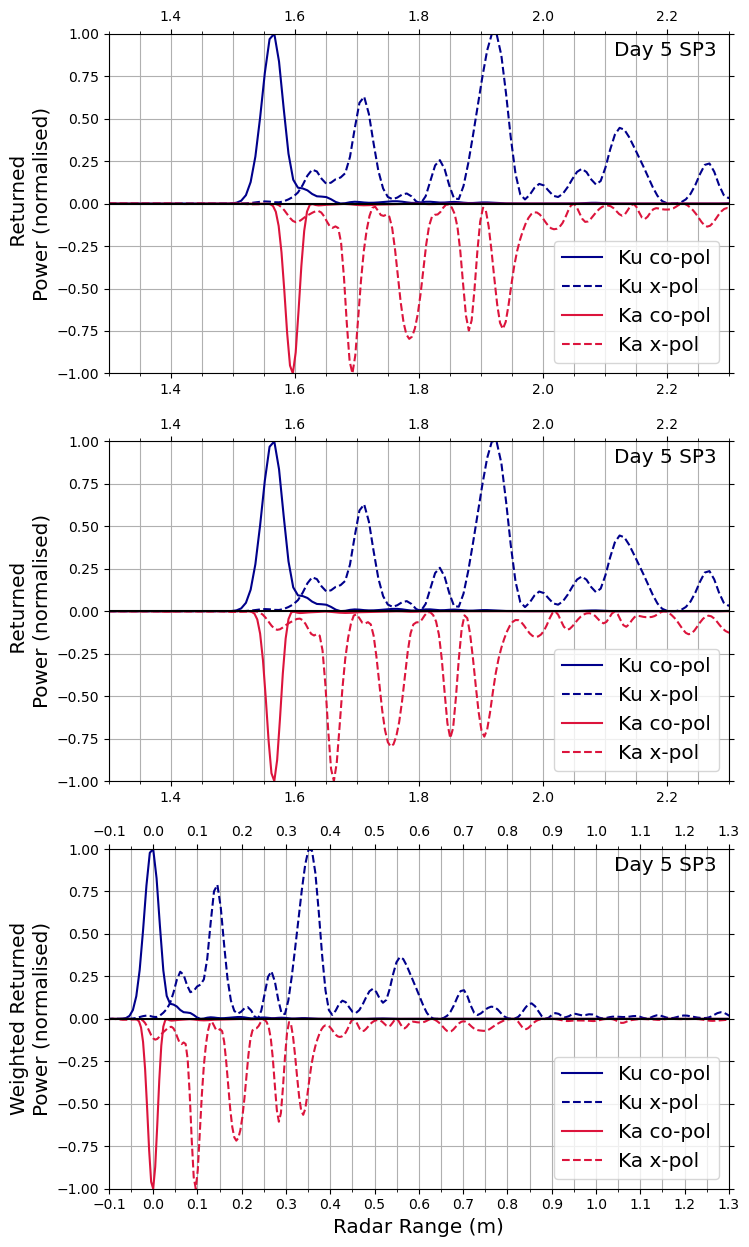

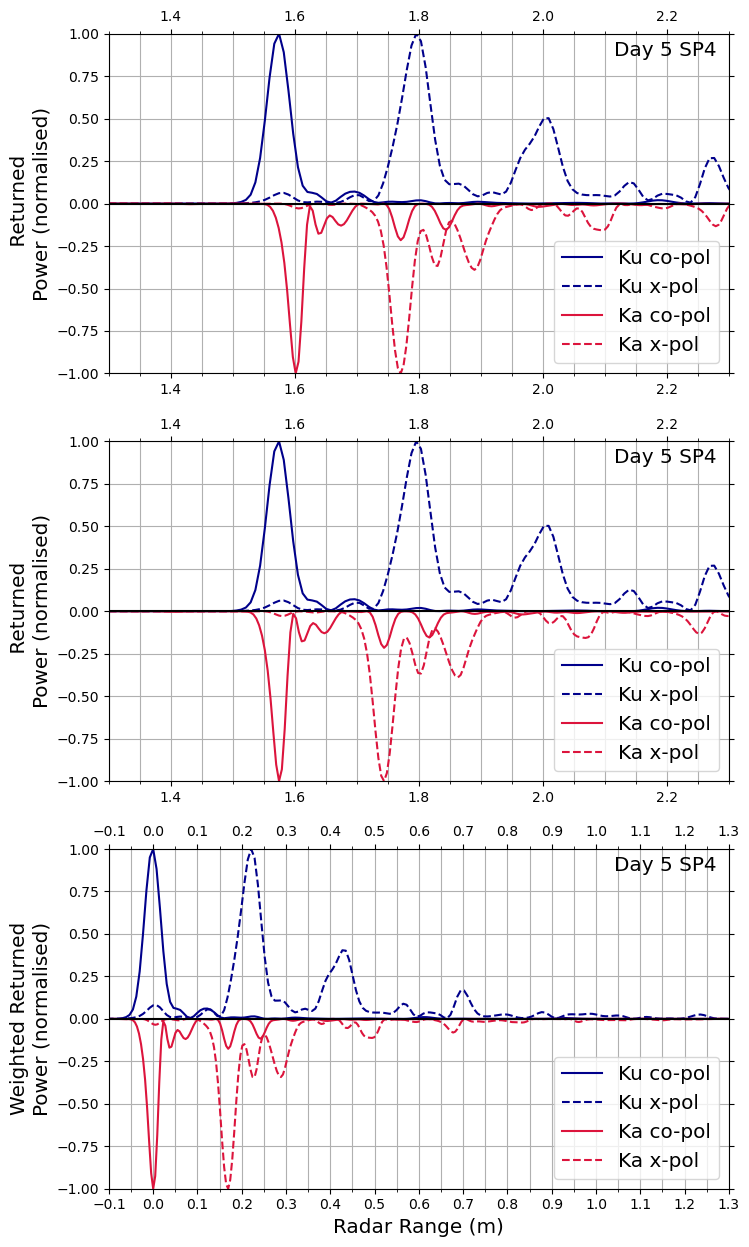

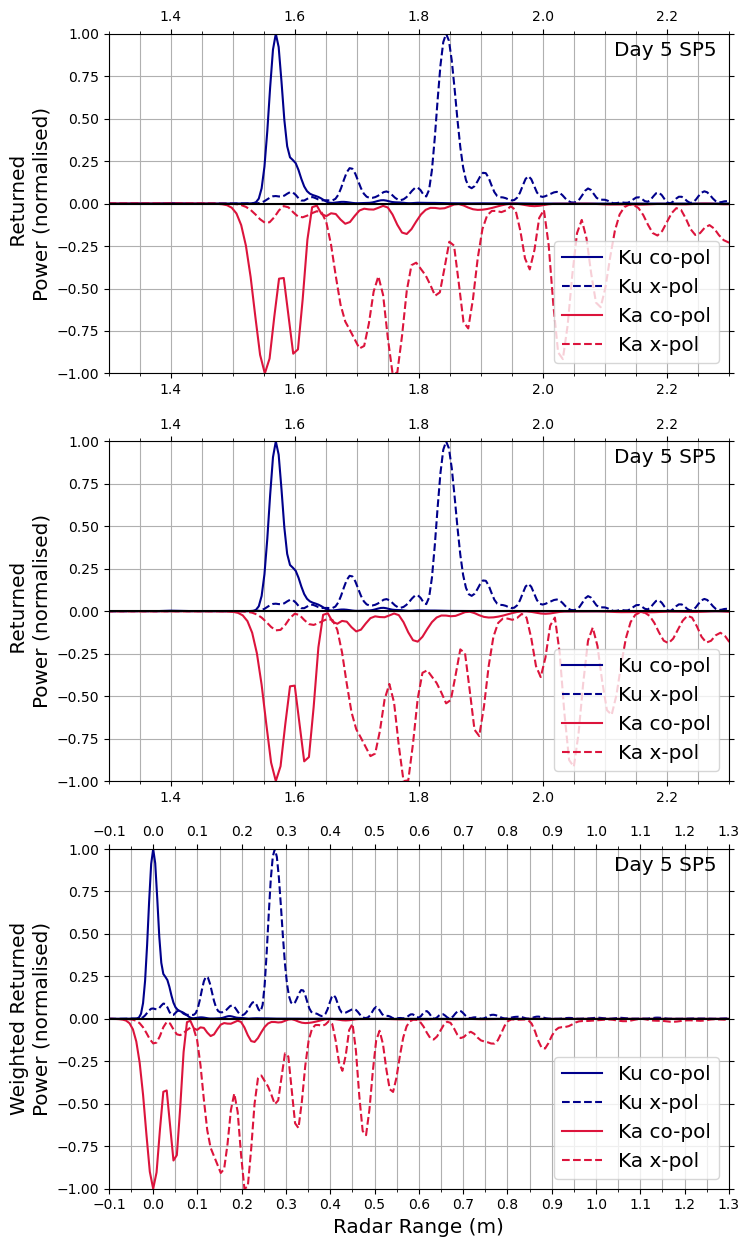

In [108]:
for pit_name, dic in p.items():
    
    fig, axs = plt.subplots(3,1,figsize=(8,15))
    
    for (r2, adjust), (cp, xp), ax in zip(dic.keys(),dic.values(),axs.reshape(-1)):
        
        kuf = cp['ku_first_max'] if r2 else 0
        
        ax.plot(cp['ku_ranges']-kuf,
                cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
        ax.plot(xp['ku_ranges']-kuf,
                xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

        ax.plot(cp['ka_ranges']-kuf,
                -cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
        ax.plot(xp['ka_ranges']-kuf,
                -xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

        ax.set_ylim(-1,1)

        xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]
        ax.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax.grid(which='both')
        if r2:
            ax.set_xlim(-0.1,1.3)
            ax.set_xticks(np.arange(-0.1,1.31,0.1))
            ax.set_xlabel(f'Radar Range (m)',fontsize='x-large')

        else:
            ax.set_xlim(1.3,2.3)

        ax.annotate(pit_name,xy=(0.98,0.98),
                     va='top',ha='right',
                     fontsize='x-large',
                     xycoords='axes fraction')
        
        yl = 'Weighted' if r2 else ''

        ax.set_ylabel(f'{yl} Returned\nPower (normalised)',fontsize='x-large')
          

        ax.legend(loc='lower right',fontsize='x-large')


        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
        ax.axhline(0,color='k')
    
    plt.savefig(f'../figures/composites/{pit_name}.jpg')

    plt.show()
    
#     break

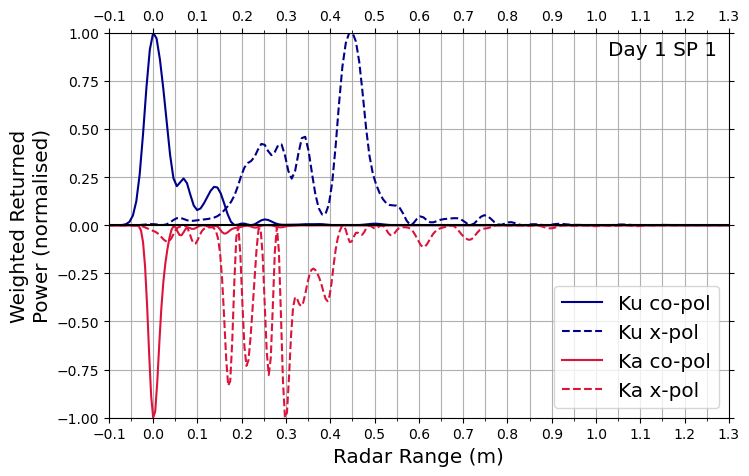

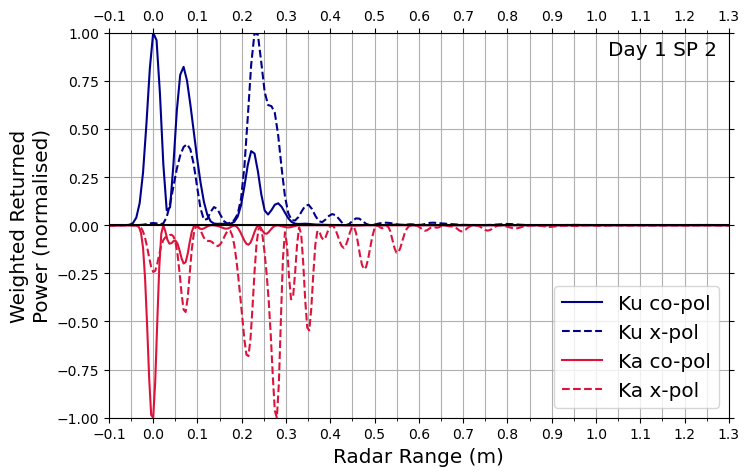

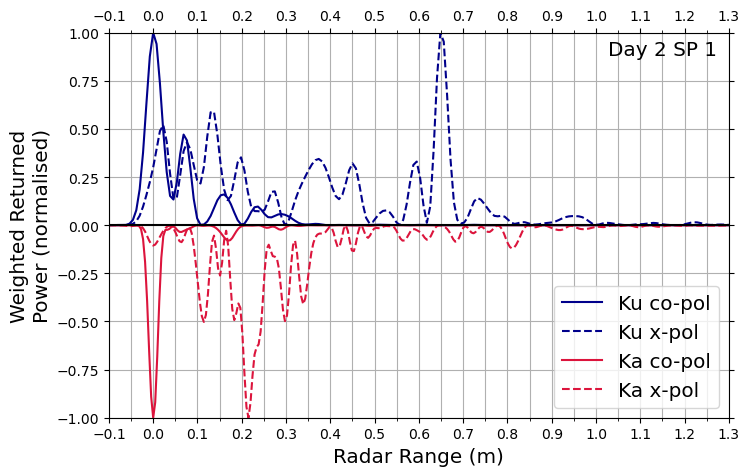

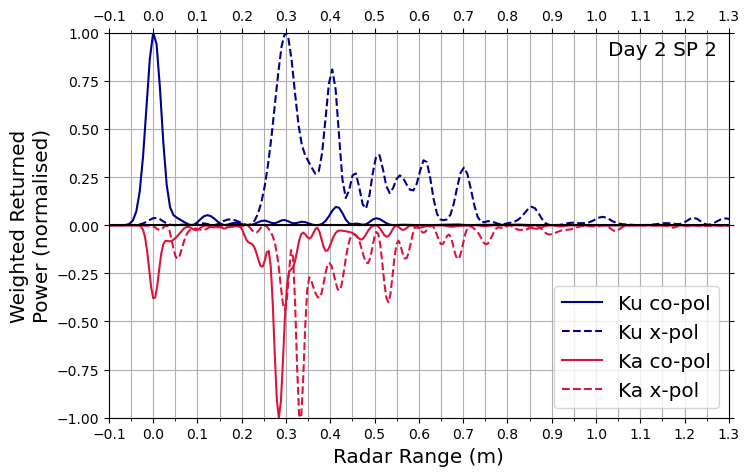

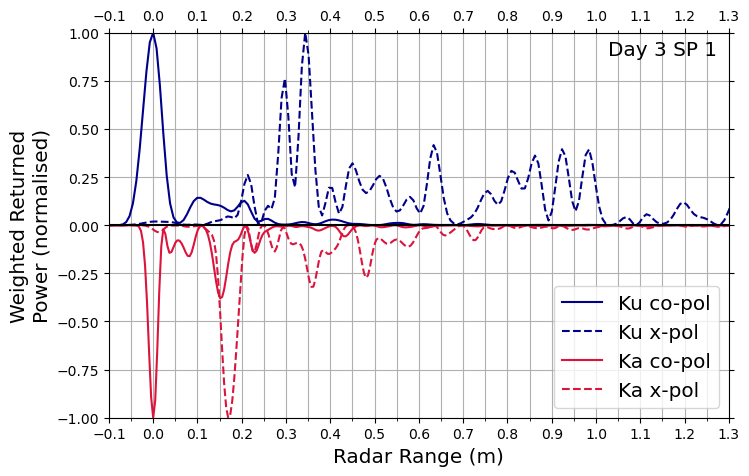

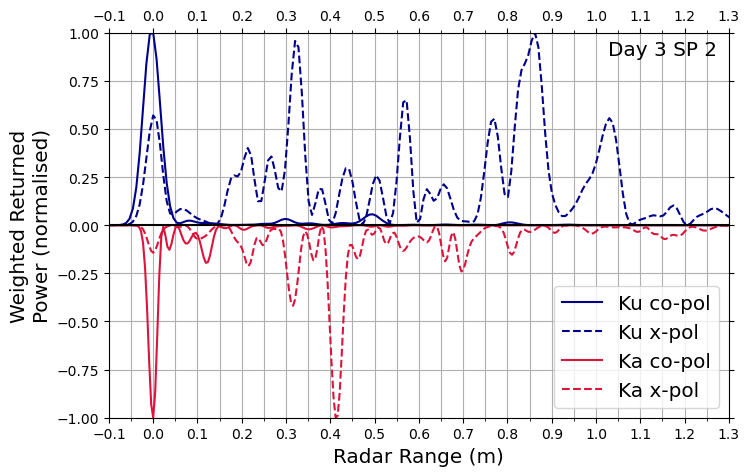

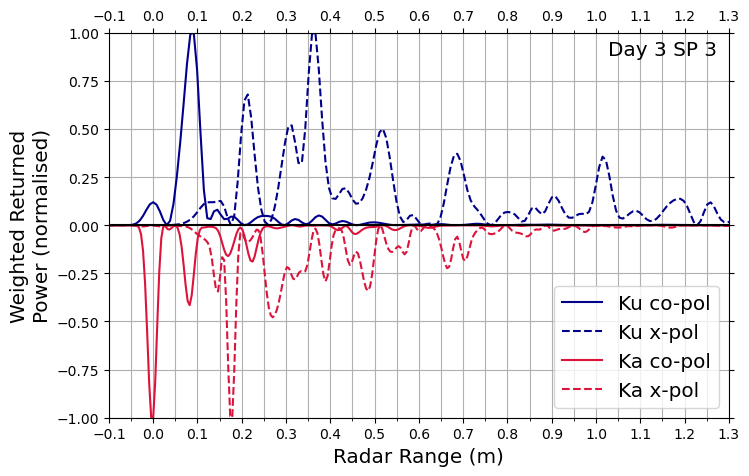

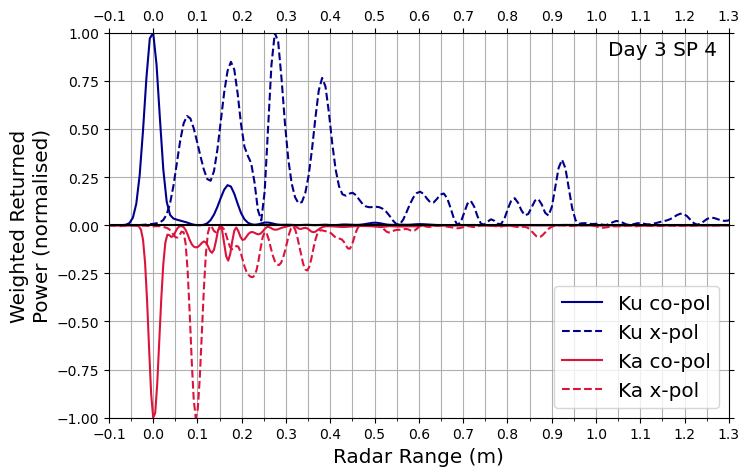

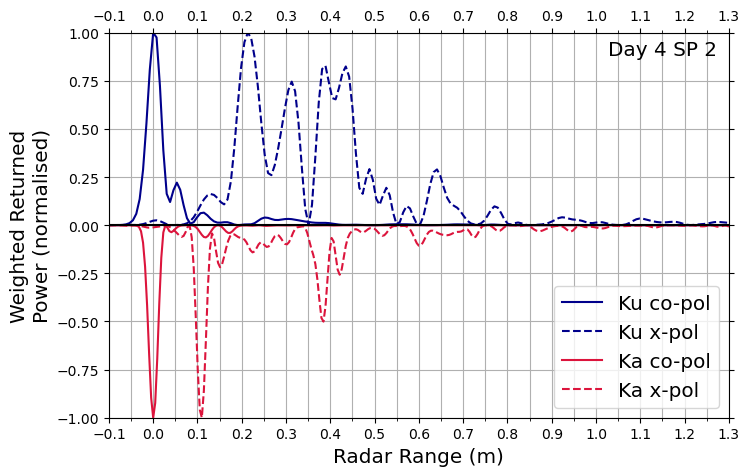

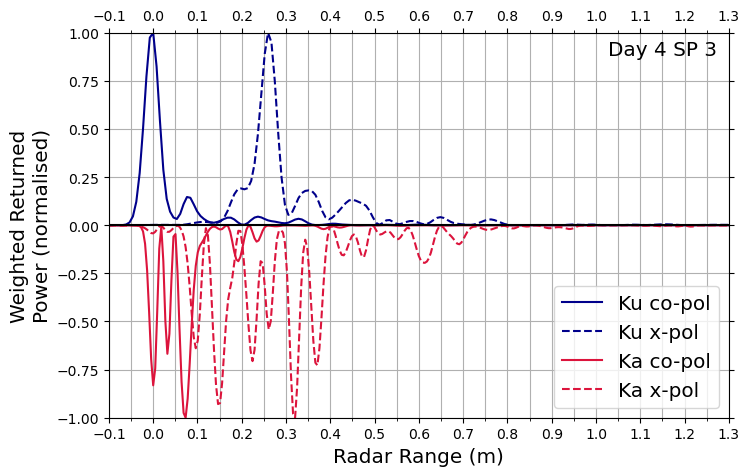

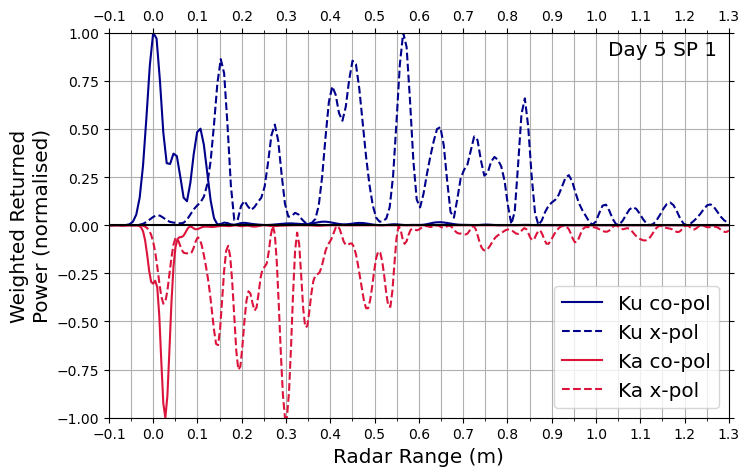

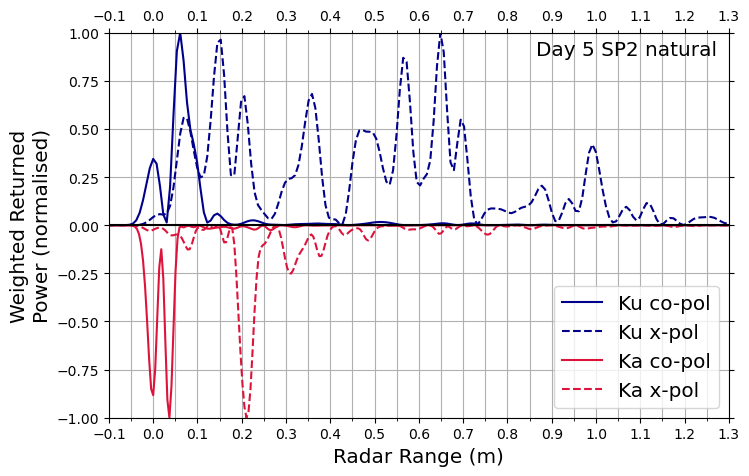

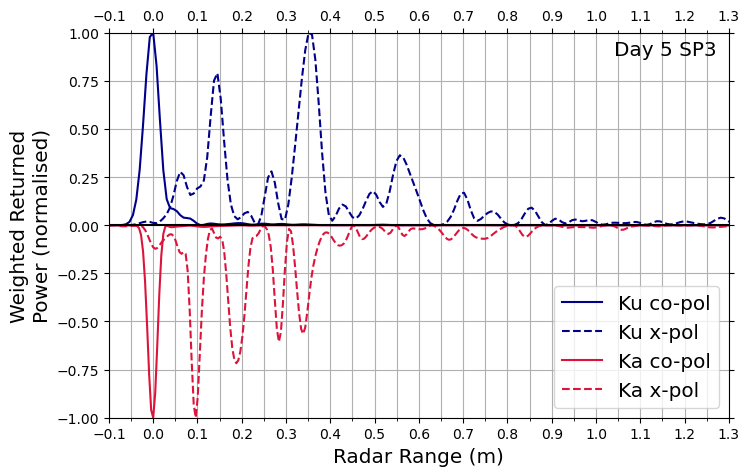

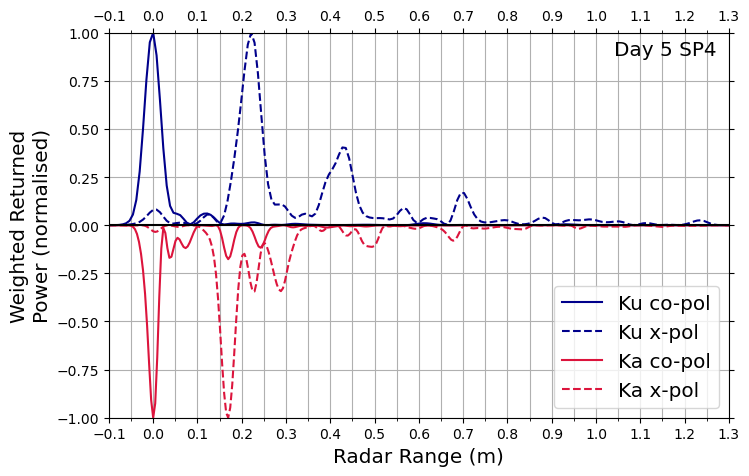

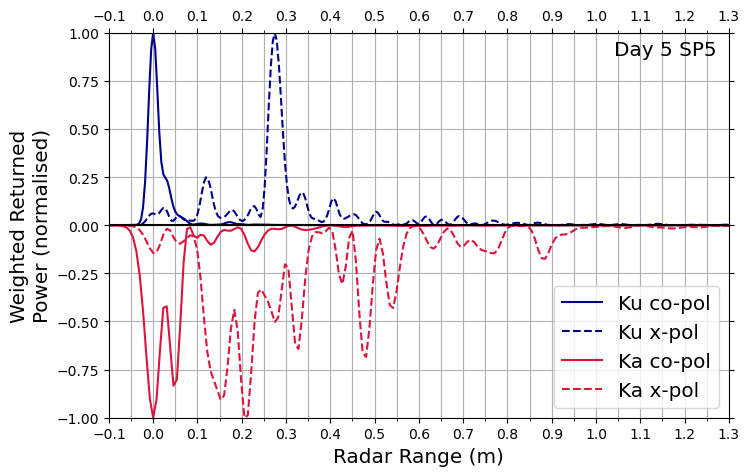

In [107]:
for pit_name, dic in p.items():
    
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    
    r2 = 1; adjust = 1
    
    (cp, xp) = list(dic.values())[-1]

    kuf = cp['ku_first_max'] if r2 else 0

    ax.plot(cp['ku_ranges']-kuf,
            cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges']-kuf,
            xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges']-kuf,
            -cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges']-kuf,
            -xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)

    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    if r2:
        ax.set_xlim(-0.1,1.3)
        ax.set_xticks(np.arange(-0.1,1.31,0.1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax.grid(which='both')
        ax.set_xlabel(f'Radar Range (m)',fontsize='x-large')

    else:
        ax.set_xlim(1.3,2.3)

    ax.annotate(pit_name,xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')

    yl = 'Weighted' if r2 else ''

    ax.set_ylabel(f'{yl} Returned\nPower (normalised)',fontsize='x-large')


    ax.legend(loc='lower right',fontsize='x-large')


    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')
    
    plt.savefig(f'../figures/r2_weighting/{pit_name}.jpg',dpi=400,bbox_inches='tight')

    plt.show()
    
#     break

# Make plots of the "basic" data

In [ ]:
for number,pit in enumerate(list_of_pits):

    cp = plot_lines(pit,scale='linear',
               normalise=True,
                   pol='vv',plot=False,
                  )
    
    xp = plot_lines(pit,scale='linear',
               normalise=True,
                   pol='vh',
                    plot=False,
                  )


    fig, ax = plt.subplots(1,1,figsize=(8,5))


    ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    ax.set_xlim(xlim-0.1,2.3)
    ax.set_xlabel('True Radar Range (m)',fontsize='x-large')
        
    ax.annotate(pit['name'],xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')
    
    ax.set_ylabel('Returned Power (normalised)',fontsize='x-large')

    ax.set_yticks(np.arange(-1,1.01,0.2))
    ax.set_yticklabels(yticks)    
    
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')

    ax.legend(loc='lower right',fontsize='x-large')
    
#     plt.savefig(f'../figures/true_ranges/{pit["name"]}.jpg',dpi=300)

#     plt.close()
    plt.show()
    
    break

# Now adjust the Ka-band data to match the ku-band data

In [ ]:
for number,pit in enumerate(list_of_pits):

    cp = plot_lines(pit,scale='linear',
               normalise=True,
               align_ka_peak=True,
                pol='vv',
                plot=False,
                  )
    
    xp = plot_lines(pit,scale='linear',
               normalise=True,
               shift_ka_peak=cp['ka_range_diff'],
                pol='vh',
                plot=False,
                  )

    fig, ax = plt.subplots(1,1,figsize=(8,5))

    ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    ax.set_xlim(xlim-0.1,2.3)
    ax.set_xlabel('Adjusted Radar Range (m)',fontsize='x-large')
        
    ax.annotate(pit['name'],xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')
    
    ax.set_ylabel('Returned Power (normalised)',fontsize='x-large')

    ax.set_yticks(np.arange(-1,1.01,0.2))
    ax.set_yticklabels(yticks)    

    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')
    
    ax.legend(loc='lower right',fontsize='x-large')

#     plt.savefig(f'../figures/aligned_ranges/{pit["name"]}.jpg',dpi=300)
    
#     plt.close()
    
    plt.show()
    
#     break

# Now perform the inverse square weighting

In [ ]:
yticks = [1,0.5,0,0.5,1]


fig, axs = plt.subplots(4,4,figsize=(10,10))


for counter, (ax,pit) in enumerate(zip(axs.reshape(-1),list_of_pits.values())):

    cp = plot_lines(pit,scale='linear',
               normalise=False,
               align_ka_peak=True,
                pol='vv',
                r2_weighting=True,
                plot=False,
                  )
    
    print(pit['name'],cp['ka_range_diff'])
    
#     xp = plot_lines(pit,scale='linear',
#                normalise=False,
#                shift_ka_peak=cp['ka_range_diff'],
#                 pol='vh',
#             r2_weighting=True,
#                 plot=False,
#                   )


    ax.plot(cp['ka_ranges']-cp['ku_first_max'],
            cp['ka_values'],
            color='darkblue',
            ls='-',label='Ku co-pol')
#     ax.plot(xp['ku_ranges']-cp['ku_first_max'],
#             xp['ku_values'],
#             color='darkblue',
#             ls='--',label='Ku x-pol')

#     ax.plot(cp['ka_ranges']-cp['ku_first_max'],
#             -cp['ka_values']
#             ,color='crimson',
#             ls='-',label='Ka co-pol')
#     ax.plot(xp['ka_ranges']-cp['ku_first_max'],
#             -xp['ka_values']
#             ,color='crimson',
#             ls='--',label='Ka x-pol')

#     ax.set_ylim(-1,1)
    
    ax.set_xlim(-0.1,1.1)
    


        
    ax.annotate(get_code_from_name(pit['name']),xy=(0.98,0.02),
                 va='bottom',ha='right',
                 fontsize='large',
                 xycoords='axes fraction')
    

#     ax.set_yticks(np.arange(-1,1.01,0.5))
#     ax.set_yticklabels(yticks)    
    
#     if counter == 1:
#         ax.legend(loc='center',fontsize='x-large',ncol=2,bbox_to_anchor=(0.5,1.4))
    
#     ax.set_xticks(np.arange(0,1.01,0.2))
    
#     ax.xaxis.set_ticks_position('both')
#     if counter <4:
#         ax.tick_params(labelbottom=False,labeltop=True)
#     elif counter > 11:
#         ax.tick_params(labelbottom=True,labeltop=False)
#     else:
#         ax.set_xticklabels([])
#         ax.tick_params(labelbottom=False,labeltop=False)
        
#     ax.yaxis.set_ticks_position('both')
    
#     if counter in [0,4,8,12]:
#         ax.tick_params(labelleft=True)
#     elif counter in [3,7,11,15]:
#         ax.tick_params(labelleft=False,labelright=True)
#     else:
#         ax.set_yticklabels([])
        
#     ax.axhline(0,color='k')
    
    if counter == 4: ax.set_ylabel('Weighted Returned Power (normalised)',
                                   fontsize='x-large',va='bottom')

    if counter == 13: ax.set_xlabel('Adjusted Radar Range\nBelow Snow Surface (m)',fontsize='x-large',ha='left')


    ax.set_ylim(0,0.005)
# fig.subplots_adjust(wspace=0.03,hspace=0.03)

# plt.show()
# plt.savefig(f'../figures/all_pits.jpg',dpi=300,bbox_inches='tight')

#     plt.close()